In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/My\ Drive/

In [ ]:
!pip install pmdarima

# Load and View Data

- Loading all 7 data tables

In [ ]:
# 'skus' table
skus = pd.read_csv('JD_sku_data.csv', na_values='-')
# 'users' table
users = pd.read_csv('JD_user_data.csv', na_values='-')
# 'clicks' table
clicks = pd.read_csv('JD_click_data.csv', na_values='-')
# 'orders' table
orders = pd.read_csv('JD_order_data.csv', na_values='-', parse_dates=True, index_col='order_time')
# 'delivery' table
delivery = pd.read_csv('JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('JD_network_data.csv')

- Sample of ___skus___ table

In [ ]:
skus.head()

,sku_ID,type,brand_ID,attribute1,attribute2,activate_date,deactivate_date
0,a234e08c57,1,c3ab4bf4d9,3.0,60.0,NaN,NaN
1,6449e1fd87,1,1d8b4b4c63,2.0,50.0,NaN,NaN
2,09b70fcd83,2,eb7d2a675a,3.0,70.0,NaN,NaN
3,acad9fed04,2,9b0d3a5fc6,3.0,70.0,NaN,NaN
4,2fa77e3b4d,2,b681299668,NaN,NaN,NaN,NaN


- Sample of ___user___ table

In [ ]:
users.head()

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,000089d6a6,1,2017-08,0,F,26-35,S,3,4,3
1,0000babd1f,1,2018-03,0,U,U,U,-1,-1,-1
2,0000bc018b,3,2016-06,0,F,>=56,M,3,2,3
3,0000d0e5ab,3,2014-06,0,M,26-35,M,3,2,2
4,0000dce472,3,2012-08,1,U,U,U,-1,-1,-1


- Sample of ___clicks___ table

In [ ]:
clicks.head()

,sku_ID,user_ID,request_time,channel
0,a234e08c57,4c3d6d10c2,2018-03-01 23:57:53,wechat
1,6449e1fd87,-,2018-03-01 16:13:48,wechat
2,09b70fcd83,2791ec4485,2018-03-01 22:10:51,wechat
3,09b70fcd83,eb0718c1c9,2018-03-01 16:34:08,wechat
4,09b70fcd83,59f84cf342,2018-03-01 22:20:35,wechat


- Sample of ___orders___ table

In [ ]:
orders.head().T

order_time,2018-03-01 17:14:25,2018-03-01 11:10:40,2018-03-01 09:13:26,2018-03-01 21:29:50,2018-03-01 19:13:37
order_ID,d0cf5cc6db,7444318d01,f973b01694,8c1cec8d4b,d43a33c38a
user_ID,0abe9ef2ce,33a9e56257,4ea3cf408f,b87cb736cb,4829223b6f
sku_ID,581d5b54c1,067b673f2b,623d0a582a,fc5289b139,623d0a582a
order_date,2018-03-01,2018-03-01,2018-03-01,2018-03-01,2018-03-01
quantity,1,1,1,1,1
type,2,1,1,1,1
promise,NaN,2,2,2,1
original_unit_price,89,99.9,78,61,78
final_unit_price,79,53.9,58.5,35,53
direct_discount_per_unit,0,5,19.5,0,19


- Sample of ___delivery___ table

In [ ]:
delivery.head()

,package_ID,order_ID,type,ship_out_time,arr_station_time,arr_time
0,dc3d6d2258,dc3d6d2258,1,2018-03-01 08:00:00,2018-03-01 15:00:00,2018-03-01 18:00:00
1,19802a570c,19802a570c,1,2018-03-01 10:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00
2,e22627af66,e22627af66,1,2018-03-01 11:00:00,2018-03-01 15:00:00,2018-03-01 17:00:00
3,50d11a586d,50d11a586d,1,2018-03-01 10:00:00,2018-03-01 16:00:00,2018-03-01 19:00:00
4,a3bfe38bf4,a3bfe38bf4,1,2018-03-01 11:00:00,2018-03-01 16:00:00,2018-03-01 17:00:00


- Sample of ___inventory___ table

In [ ]:
inventory.head()

,dc_ID,sku_ID,date
0,9,50f6f91962,2018-03-01
1,9,7f0ddbcdde,2018-03-01
2,9,8ad5789d74,2018-03-01
3,9,468d34eda4,2018-03-01
4,9,460afaddb6,2018-03-01


- Sample of ___network___ table

In [ ]:
network.head()

,region_ID,dc_ID
0,2,57
1,2,43
2,2,42
3,2,66
4,2,20


# An Illustrating Example of Full Customer Experience Cycle

We first randomly select a customer order with order_ID ‘___81a6fa818d___’ from the order table. The data below shows the information in ___orders___ table corresponding to the order.

In [ ]:
orders[orders['order_ID']=='81a6fa818d'].T

,47253,47254
order_ID,81a6fa818d,81a6fa818d
user_ID,2c511cbd9e,2c511cbd9e
sku_ID,ac61f4e10e,eb3f2d2fd8
order_date,2018-03-02,2018-03-02
order_time,2018-03-02 00:04:44.0,2018-03-02 00:04:44.0
quantity,1,1
type,1,1
promise,1,1
original_unit_price,139.9,139.9
final_unit_price,82.9,82.9


- From the order table, we find that this order is placed by customer ‘2c511cbd9e’ on ‘2018-03-02’ and contains two SKUs with sku_ID ‘ac61f4e10e’ and 'eb3f2d2fd8'.
- Also, we find that the customer took discount from a quantity discount of a total value RMB 100 _[calculated as 100 = 50 (unit discount for sku 'ac61f4e10e') * 1 (quantity for sku 'ac61f4e10e') + 50 (unit discount for sku 'eb3f2d2fd8') * 1 (quantity for sku 'eb3f2d2fd8')]_, a direct discount of a total value RMB 14 and no other discounts.
- The order is shipped from warehouse in district 9 to destination district 27.

Taking a deeper look at the customer with user_ID '2c511cbd9e' from ___users___ table.

In [ ]:
users[users['user_ID']=='2c511cbd9e']

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
79944,2c511cbd9e,3,2015-06,0,F,26-35,M,3,1,2


- By looking up the customer ‘2c511cbd9e’ in the ___users___ table, we find that this is a level 3 user with no PLUS membership who has been with JD.com since 2015-06.
- The customer's most common shipping address is in a tier 1 city.
- The customer is estimated to be a married (marital_status = 'M') female customer (gender = 'F') in her 26-35th (age = '26-35') with a Bachelor degree (education = 3) and relatively high purchase power (purchase_power = 2).

Now checking the information available in the ___skus___ table for the related SKUs.

In [ ]:
skus[skus['sku_ID'].isin(['ac61f4e10e','eb3f2d2fd8'])]

,sku_ID,type,brand_ID,attribute1,attribute2,activate_date,deactivate_date
1986,eb3f2d2fd8,1,9b0d3a5fc6,-,-,NaN,NaN
2813,ac61f4e10e,1,9b0d3a5fc6,3.0,80.0,NaN,NaN


- By looking up the two SKUs bought in the ___skus___ table, we find that both of them are 1P skus and of the same brand. However, one item is missing the two provided attributes.
- Both SKUs do not have activate_date and deactivate_date listed, meaning both SKUs are available for purchase during the whole month.

___clicks___ table can also provide further information on how this purchase happened.

In [ ]:
clicks[clicks['user_ID']=='2c511cbd9e'].sort_values('request_time')

- By looking up the same customer in the ___clicks___ table, we find that the customer has been browsing several items before making the purchase decision. 
- The sequence of browsing may suggest the customer was actively comparing between these substitutes as we see many back and forth clicks between several SKUs.

Now we look at how the order is fulfilled. Firstly we can look at the warehouse that is used to fulfill the order from ___orders___ table.

In [ ]:
orders[orders['order_ID']=='81a6fa818d'][['sku_ID', 'dc_ori', 'dc_des']]

,sku_ID,dc_ori,dc_des
47253,ac61f4e10e,9,27
47254,eb3f2d2fd8,9,27


- We can see that both SKUs are shipped from a wharehouse in district 9 to district 27 which is the final destination.

The ___delivery___ table can provide more details on the shipment information

In [ ]:
delivery[delivery['order_ID']=='81a6fa818d']

,package_ID,order_ID,type,ship_out_time,arr_station_time,arr_time
10415,81a6fa818d,81a6fa818d,1,2018-03-02 08:00:00,2018-03-02 15:00:00,2018-03-02 16:00:00


- By looking up order '81a6fa818d' in the delivery table, we find that there is only one record, meaning the two purchased items are shipped together in one package. The associated package shipped out from warehouse shortly after the order is placed and arrived at the customer address in the morning of the next day.

The ___inventory___ table would be able to provide more insights on the fulfillment logic.

In [ ]:
inventory[(inventory['sku_ID'].isin(['ac61f4e10e','eb3f2d2fd8'])) & \
          (inventory['date']=='2018-03-01') & (inventory['dc_ID']==27)]

,dc_ID,sku_ID,date


In [ ]:
inventory[(inventory['sku_ID'].isin(['ac61f4e10e','eb3f2d2fd8'])) & \
          (inventory['date']=='2018-03-01') & (inventory['dc_ID']==9)]

,dc_ID,sku_ID,date
1007,9,ac61f4e10e,2018-03-01
2020,9,eb3f2d2fd8,2018-03-01


- Note that the first statement returns no results, meaning warehouses in district 27 does not have any inventory of any of the SKUs.
- The second statement returns two records, one for each SKU. This suggusts both SKUs are available in the warehouse.
- This explains why the order is fulfilled from a remote warehouse (dc_ori is not the same as dc_des).

In [ ]:
network[network['dc_ID'].isin([9, 27])]

,region_ID,dc_ID
38,9,9
41,9,27


- When dc_ID = region_ID, the warehouses in this district are used as "central warehouses" for "back-up fulfillment" when local warehouses are run out of inventory or does not store the SKUs. In this particular case, dc_ID 9 is central warehouse. As we see previous that warehouses in disctrict 27 do not have any inventory for the two ordered SKUs, a warehouse in district 9 is used for the fulfillment of this order.

# skus data visualization

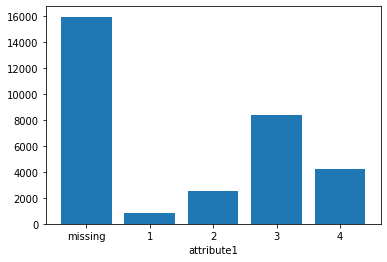

In [ ]:
height=[len(skus[pd.isna(skus['attribute1'])]),len(skus[skus['attribute1']==1]), len(skus[skus['attribute1']==2]), len(skus[skus['attribute1']==3]), len(skus[skus['attribute1']==4])]
bars=('missing','1', '2', '3', '4')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel('attribute1')
plt.show()

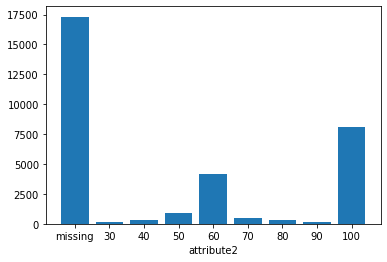

In [ ]:
height=[len(skus[pd.isna(skus['attribute2'])]),len(skus[skus['attribute2']==30]), len(skus[skus['attribute2']==40]), len(skus[skus['attribute2']==50]), len(skus[skus['attribute2']==60]), len(skus[skus['attribute2']==70]), len(skus[skus['attribute2']==80]), len(skus[skus['attribute2']==90]), len(skus[skus['attribute2']==100])]
bars=('missing','30', '40', '50', '60', '70', '80', '90', '100')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel('attribute2')
plt.show()

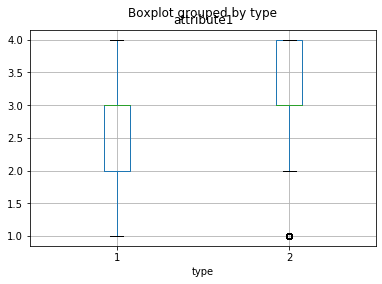

In [ ]:
skus.boxplot(column='attribute1', by='type')

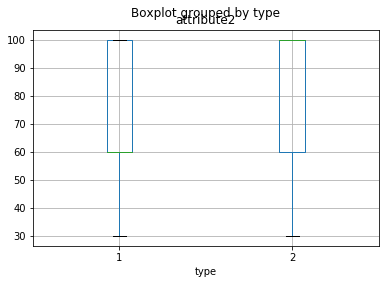

In [ ]:
skus.boxplot(column='attribute2', by='type')

# users data visualization

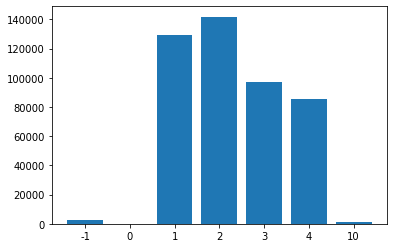

In [ ]:
height=[len(users[users['user_level']==-1]), len(users[users['user_level']==0]), len(users[users['user_level']==1]), len(users[users['user_level']==2]), len(users[users['user_level']==3]),len(users[users['user_level']==4]),len(users[users['user_level']==10])]
bars=('-1','0', '1', '2', '3', '4', '10')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

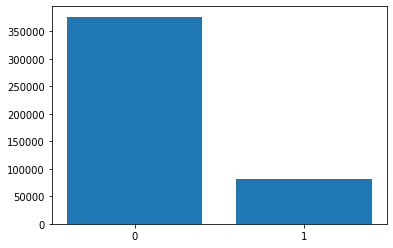

In [ ]:
height=[len(users[users['plus']==0]), len(users[users['plus']==1])]
bars=('0', '1')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

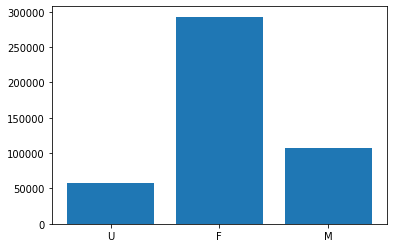

In [ ]:
height=[len(users[users['gender']=='U']), len(users[users['gender']=='F']), len(users[users['gender']=='M'])]
bars=('U', 'F', 'M')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

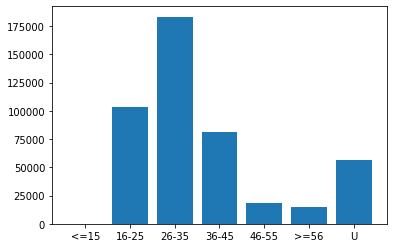

In [ ]:
height=[len(users[users['age']=='<=15']), len(users[users['age']=='16-25']), len(users[users['age']=='26-35']), len(users[users['age']=='36-45']), len(users[users['age']=='46-55']),len(users[users['age']=='>=56']),len(users[users['age']=='U'])]
bars=('<=15','16-25', '26-35', '36-45', '46-55', '>=56', 'U')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

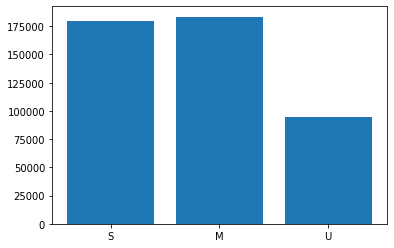

In [ ]:
height=[len(users[users['marital_status']=='S']), len(users[users['marital_status']=='M']), len(users[users['marital_status']=='U'])]
bars=('S', 'M', 'U')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

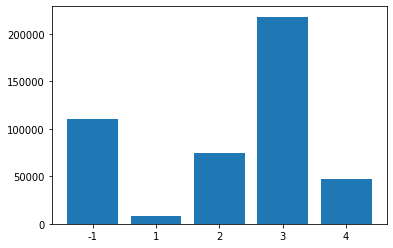

In [ ]:
height=[len(users[users['education']==-1]), len(users[users['education']==1]), len(users[users['education']==2]), len(users[users['education']==3]),len(users[users['education']==4])]
bars=('-1', '1', '2', '3', '4')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

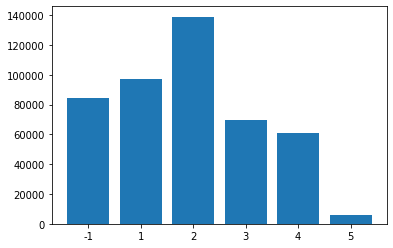

In [ ]:
height=[len(users[users['city_level']==-1]), len(users[users['city_level']==1]), len(users[users['city_level']==2]), len(users[users['city_level']==3]),len(users[users['city_level']==4]), len(users[users['city_level']==5])]
bars=('-1', '1', '2', '3', '4', '5')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

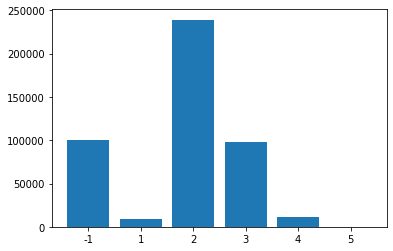

In [ ]:
height=[len(users[users['purchase_power']==-1]), len(users[users['purchase_power']==1]), len(users[users['purchase_power']==2]), len(users[users['purchase_power']==3]),len(users[users['purchase_power']==4]), len(users[users['purchase_power']==5])]
bars=('-1', '1', '2', '3', '4', '5')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

In [ ]:
users['mean_price']=np.nan

In [ ]:
for x in users['user_ID'].iloc[0:45000]:
    a=0
    n=0
    for index, y in enumerate(orders['user_ID']):
        if y==x:
                n=n+1
                a=a+orders['original_unit_price'].iloc[index]
    if n>0:
        users['mean_price'][users['user_ID']==x]=a/n

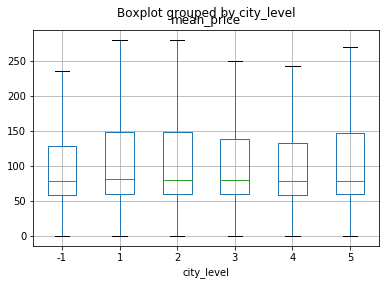

In [ ]:
users.boxplot(column='mean_price', by='city_level', showfliers=False)

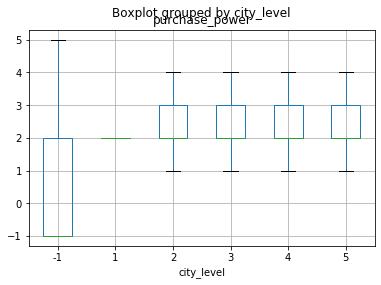

In [ ]:
users.boxplot(column='purchase_power', by='city_level', showfliers=False)

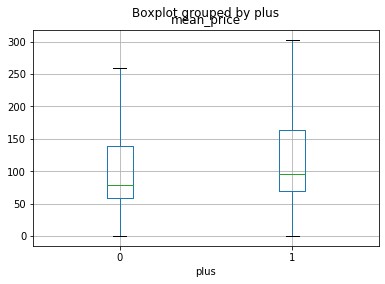

In [ ]:
users.boxplot(column='mean_price', by='plus', showfliers=False)

In [ ]:
clicks['price']=np.nan

In [ ]:
for index, x in enumerate(clicks['sku_ID']):
    for index2, y in enumerate(orders['sku_ID']):
        if y==x:
            k=orders['original_unit_price'][index2]
            break
    clicks['price'][index]=k

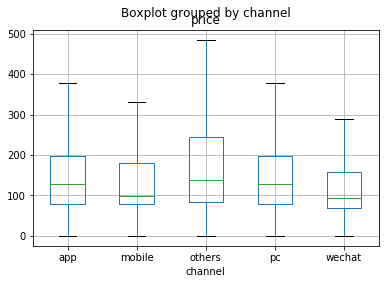

In [ ]:
newclicks.boxplot(column='price', by='channel', showfliers=False)

In [ ]:
clicks['age2']=np.nan

In [ ]:
k=1

In [ ]:
for index, x in enumerate(clicks['user_ID']):
    for index2, y in enumerate(users['user_ID']):
        if y==x:
            k=users['age'][index2]
            a='y'
            break
        else:
          a='n'
    if a=='y':  
      clicks['age2'][index]=k

    if index % 50000==0:
      print(index)
      clicks.to_csv(r'gdrive/My Drive/click_age.csv', index=False)

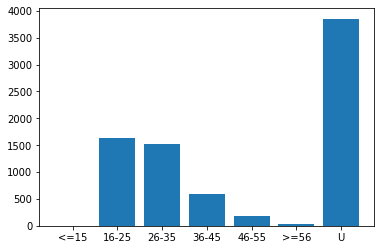

In [ ]:
wechatusers=clicks[clicks['channel']=='wechat']
height=[len(wechatusers[wechatusers['age2']=='<=15']), len(wechatusers[wechatusers['age2']=='16-25']), len(wechatusers[wechatusers['age2']=='26-35']), len(wechatusers[wechatusers['age2']=='36-45']), len(wechatusers[wechatusers['age2']=='46-55']),len(wechatusers[wechatusers['age2']=='>=56']),len(wechatusers[wechatusers['age2']=='U'])]
bars=('<=15','16-25', '26-35', '36-45', '46-55', '>=56', 'U')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

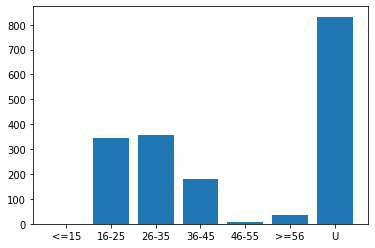

In [ ]:
appusers=clicks[clicks['channel']=='app']
height=[len(appusers[appusers['age2']=='<=15']), len(appusers[appusers['age2']=='16-25']), len(appusers[appusers['age2']=='26-35']), len(appusers[appusers['age2']=='36-45']), len(appusers[appusers['age2']=='46-55']),len(appusers[appusers['age2']=='>=56']),len(appusers[appusers['age2']=='U'])]
bars=('<=15','16-25', '26-35', '36-45', '46-55', '>=56', 'U')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

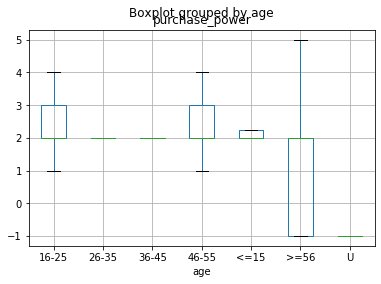

In [ ]:
users.boxplot(column='purchase_power', by='age', showfliers=False)

# orders data visualization

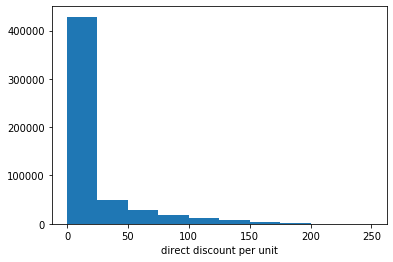

In [ ]:
plt.hist(orders['direct_discount_per_unit'], bins=10, range=(0,250))
plt.xlabel('direct discount per unit')
plt.show()

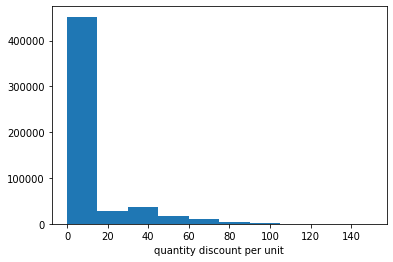

In [ ]:
plt.hist(orders['quantity_discount_per_unit'], bins=10, range=(0,150))
plt.xlabel('quantity discount per unit')
plt.show()

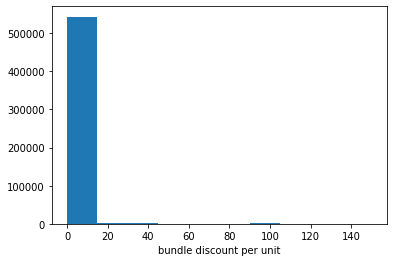

In [ ]:
plt.hist(orders['bundle_discount_per_unit'], bins=10, range=(0,150))
plt.xlabel('bundle discount per unit')
plt.show()

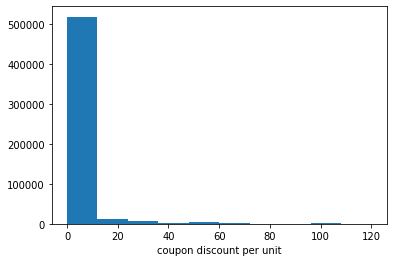

In [ ]:
plt.hist(orders['coupon_discount_per_unit'], bins=10, range=(0,120))
plt.xlabel('coupon discount per unit')
plt.show()

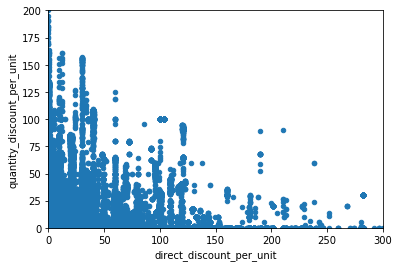

In [ ]:
orders.plot(x='direct_discount_per_unit', y='quantity_discount_per_unit', kind='scatter')
plt.xlim(0, 300)
plt.ylim(0,200)
plt.show()

In [ ]:
orders[['direct_discount_per_unit','quantity_discount_per_unit']].corr()

,direct_discount_per_unit,quantity_discount_per_unit
direct_discount_per_unit,1.000000,-0.114672
quantity_discount_per_unit,-0.114672,1.000000


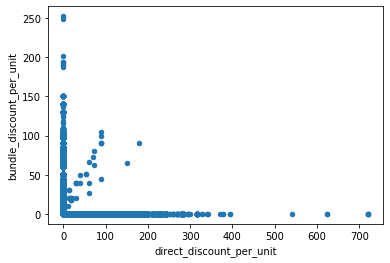

In [ ]:
orders.plot(x='direct_discount_per_unit', y='bundle_discount_per_unit', kind='scatter')
plt.show()

In [ ]:
orders[['direct_discount_per_unit','bundle_discount_per_unit']].corr()

,direct_discount_per_unit,bundle_discount_per_unit
direct_discount_per_unit,1.000000,-0.056414
bundle_discount_per_unit,-0.056414,1.000000


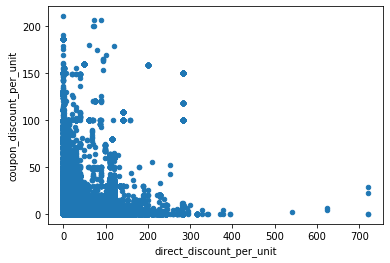

In [ ]:
orders.plot(x='direct_discount_per_unit', y='coupon_discount_per_unit', kind='scatter')

plt.show()

In [ ]:
orders[['direct_discount_per_unit','coupon_discount_per_unit']].corr()

,direct_discount_per_unit,coupon_discount_per_unit
direct_discount_per_unit,1.000000,0.065869
coupon_discount_per_unit,0.065869,1.000000


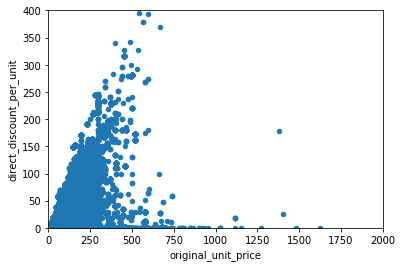

In [ ]:
orders.plot(x='original_unit_price', y='direct_discount_per_unit',  kind='scatter')
plt.xlim(0, 2000)
plt.ylim(0,400)
plt.show()

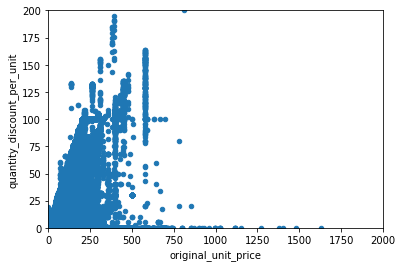

In [ ]:
orders.plot(x='original_unit_price', y='quantity_discount_per_unit',  kind='scatter')
plt.xlim(0, 2000)
plt.ylim(0,200)
plt.show()

In [ ]:
orders['mean_direct_discount']=np.nan


In [ ]:
orders['total_quantity']=np.nan

In [ ]:
L=[]
for x in orders['sku_ID']:
    A=[]
    if x not in L:
        L.append(x)
        a=0
        n=0
        for index, y in enumerate(orders['sku_ID']):
            if y==x:
                A.append(index)
                n=n+1
                a= a + orders['direct_discount_per_unit'].iloc[index]
        orders['mean_direct_discount'].iloc[A[0]]=a/n

In [ ]:
for index1, x in enumerate(orders['sku_ID']):
    if pd.notna(orders['mean_direct_discount'].iloc[index1]):
        q=0
        A=[]
        for index2, y in enumerate(orders['sku_ID']):
            if y==x:
                A.append(index2)
                q=q+orders['quantity'].iloc[index2]
        orders['total_quantity'].iloc[A[0]]=q
            

    

In [ ]:
orders[['mean_direct_discount','total_quantity']]

,mean_direct_discount,total_quantity
0,6.094857,1692.0
1,2.771203,2213.0
2,17.531695,13474.0
3,0.868633,801.0
4,NaN,NaN
...,...,...
549984,NaN,NaN
549985,NaN,NaN
549986,NaN,NaN
549987,NaN,NaN


In [ ]:
orders['direct_discount_proportion']=orders['mean_direct_discount']/orders['original_unit_price']

In [ ]:
orders[['direct_discount_proportion','mean_direct_discount', 'original_unit_price']]

,direct_discount_proportion,mean_direct_discount,original_unit_price
0,0.068482,6.094857,89.0
1,0.027740,2.771203,99.9
2,0.224765,17.531695,78.0
3,0.014240,0.868633,61.0
4,NaN,NaN,78.0
...,...,...,...
549984,NaN,NaN,0.0
549985,NaN,NaN,118.0
549986,NaN,NaN,78.0
549987,NaN,NaN,189.0


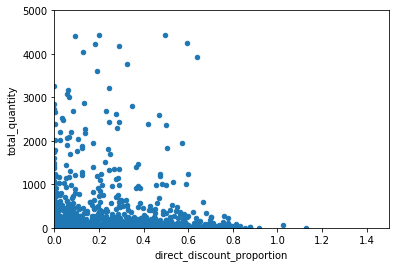

In [ ]:
orders.plot(x='direct_discount_proportion', y='total_quantity', kind='scatter')
plt.xlim(0, 1.5)
plt.ylim(0,5000)
plt.show()

In [ ]:
orders[['direct_discount_proportion','total_quantity']].corr()

,direct_discount_proportion,total_quantity
direct_discount_proportion,1.000000,0.043877
total_quantity,0.043877,1.000000


In [ ]:
orders['mean_quantity_discount']=np.nan

In [ ]:
L=[]
for x in orders['sku_ID']:
    A=[]
    if x not in L:
        L.append(x)
        a=0
        n=0
        for index, y in enumerate(orders['sku_ID']):
            if y==x:
                A.append(index)
                n=n+1
                a= a + orders['quantity_discount_per_unit'].iloc[index]
        orders['mean_quantity_discount'].iloc[A[0]]=a/n

In [ ]:
orders['quantity_discount_proportion']=orders['mean_quantity_discount']/orders['original_unit_price']

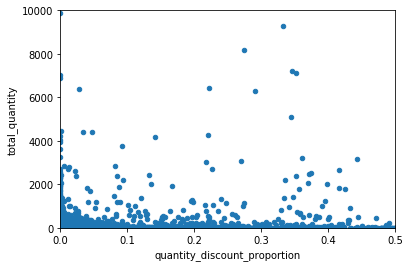

In [ ]:
orders.plot(x='quantity_discount_proportion', y='total_quantity',  kind='scatter')
plt.xlim(0, 0.5)
plt.ylim(0, 10000)
plt.show()

In [ ]:
orders[['quantity_discount_proportion','total_quantity']].corr()

,quantity_discount_proportion,total_quantity
quantity_discount_proportion,1.000000,0.103538
total_quantity,0.103538,1.000000


In [ ]:
orders['mean_bundle_discount']=np.nan

In [ ]:
L=[]
for x in orders['sku_ID']:
    A=[]
    if x not in L:
        L.append(x)
        a=0
        n=0
        for index, y in enumerate(orders['sku_ID']):
            if y==x:
                A.append(index)
                n=n+1
                a= a + orders['bundle_discount_per_unit'].iloc[index]
        orders['mean_bundle_discount'].iloc[A[0]]=a/n

In [ ]:
orders['bundle_discount_proportion']=orders['mean_bundle_discount']/orders['original_unit_price']

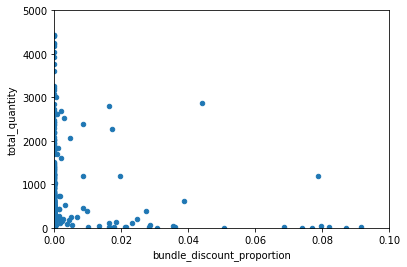

In [ ]:
orders.plot(x='bundle_discount_proportion', y='total_quantity',  kind='scatter')
plt.xlim(0,0.1)
plt.ylim(0, 5000)
plt.show()

In [ ]:
orders[['bundle_discount_proportion','total_quantity']].corr()

,bundle_discount_proportion,total_quantity
bundle_discount_proportion,1.000000,0.051784
total_quantity,0.051784,1.000000


In [ ]:
orders['mean_coupon_discount']=np.nan

In [ ]:
L=[]
for x in orders['sku_ID']:
    A=[]
    if x not in L:
        L.append(x)
        a=0
        n=0
        for index, y in enumerate(orders['sku_ID']):
            if y==x:
                A.append(index)
                n=n+1
                a= a + orders['coupon_discount_per_unit'].iloc[index]
        orders['mean_coupon_discount'].iloc[A[0]]=a/n

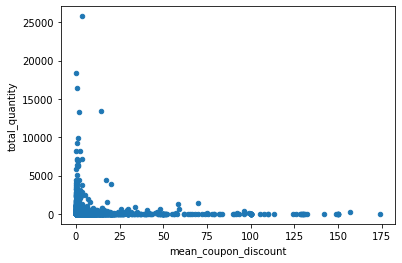

In [ ]:
orders.plot(x='mean_coupon_discount', y='total_quantity',  kind='scatter')
plt.show()

In [ ]:
orders['coupon_discount_proportion']=orders['mean_coupon_discount']/orders['original_unit_price']

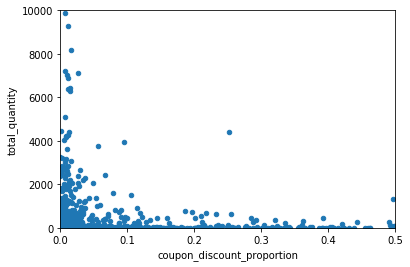

In [ ]:
orders.plot(x='coupon_discount_proportion', y='total_quantity',  kind='scatter')
plt.xlim(0,0.5)
plt.ylim(0, 10000)
plt.show()

In [ ]:
orders[['coupon_discount_proportion','total_quantity']].corr()

,coupon_discount_proportion,total_quantity
coupon_discount_proportion,1.000000,0.030458
total_quantity,0.030458,1.000000


 # Modelling

**The performance of different models for 3 different SKUs have been examined.**

In [ ]:
orders1=orders[orders['sku_ID']=="581d5b54c1"]


In [ ]:
orders2=orders[orders['sku_ID']=="067b673f2b"]

In [ ]:
orders3=orders[orders['sku_ID']=="623d0a582a"]

In [ ]:
orders1=orders1.sort_values(by=['order_time'])
orders2=orders2.sort_values(by=['order_time'])
orders3=orders3.sort_values(by=['order_time'])

## hourly

In [ ]:
columns=['quantity','average_price']

In [ ]:
A=pd.DataFrame(columns=columns)

In [ ]:
A['quantity']=orders1['quantity'].resample('H').sum()

In [ ]:
A['average_price']=orders1['final_unit_price'].resample('H').mean()

In [ ]:
isinstance(A, pd.DataFrame)

True

In [ ]:
ordersquantity1=orders1.resample('H').sum().quantity
ordersquantity2=orders2.resample('H').sum().quantity
ordersquantity3=orders3.resample('H').sum().quantity

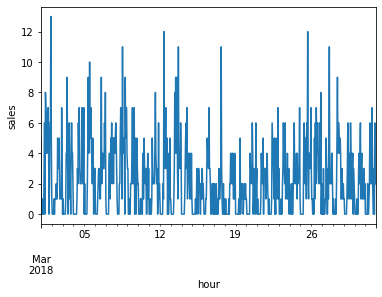

In [ ]:
ordersquantity1.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

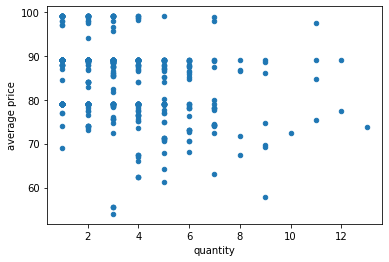

In [ ]:
A.plot(x='quantity', y='average_price', kind='scatter')
plt.xlabel('quantity')
plt.ylabel('average price')
plt.show()

In [ ]:
B=pd.DataFrame(columns=columns)

In [ ]:
B['quantity']=orders2['quantity'].resample('H').sum()

In [ ]:
B['average_price']=orders2['final_unit_price'].resample('H').mean()

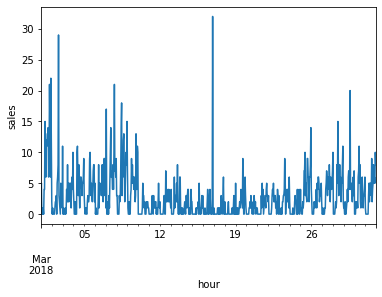

In [ ]:
ordersquantity2.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

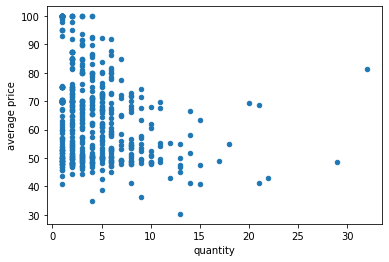

In [ ]:
B.plot(x='quantity', y='average_price', kind='scatter')
plt.xlabel('quantity')
plt.ylabel('average price')
plt.show()

In [ ]:
C=pd.DataFrame(columns=columns)

In [ ]:
C['quantity']=orders3['quantity'].resample('H').sum()

In [ ]:
C['average_price']=orders3['final_unit_price'].resample('H').mean()

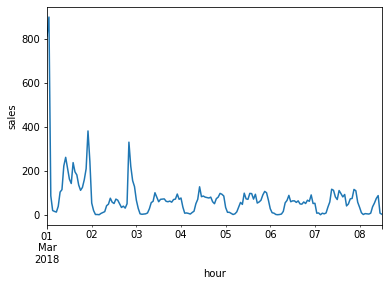

In [ ]:
ordersquantity3.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

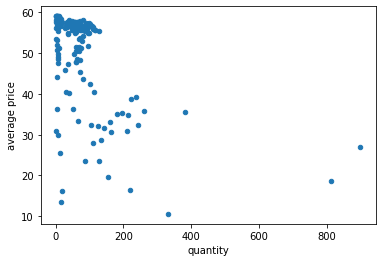

In [ ]:
C.plot(x='quantity', y='average_price', kind='scatter')
plt.xlabel('quantity')
plt.ylabel('average price')
plt.show()

## Daily

In [ ]:
ordersquantityD1=orders1.resample('D').sum().quantity
ordersquantityD2=orders2.resample('D').sum().quantity
ordersquantityD3=orders3.resample('D').sum().quantity

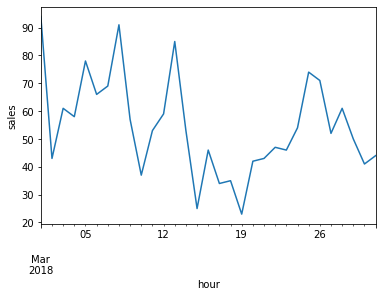

In [ ]:
ordersquantityD1.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
K=pd.DataFrame(columns=columns)

In [ ]:
K['quantity']=orders1['quantity'].resample('D').sum()

In [ ]:
K['average_price']=orders1['final_unit_price'].resample('D').mean()

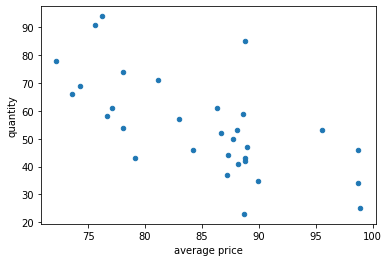

In [ ]:
K.plot(x='average_price', y='quantity', kind='scatter')
plt.xlabel('average price')
plt.ylabel('quantity')
plt.show()

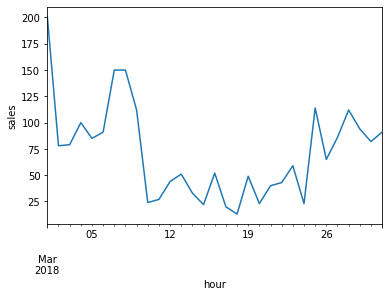

In [ ]:
ordersquantityD2.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
G=pd.DataFrame(columns=columns)

In [ ]:
G['quantity']=orders2['quantity'].resample('D').sum()

In [ ]:
G['average_price']=orders1['final_unit_price'].resample('D').mean()

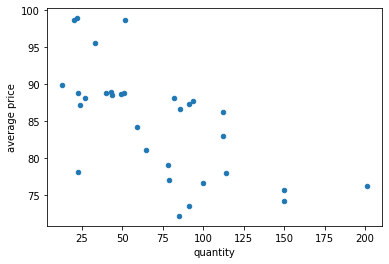

In [ ]:
G.plot(x='quantity', y='average_price', kind='scatter')
plt.xlabel('quantity')
plt.ylabel('average price')
plt.show()

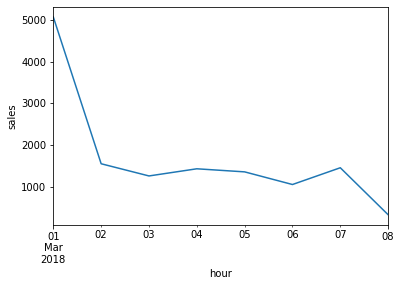

In [ ]:
ordersquantityD3.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
F=pd.DataFrame(columns=columns)

In [ ]:
F['quantity']=orders3['quantity'].resample('D').sum()

In [ ]:
F['average_price']=orders3['final_unit_price'].resample('D').mean()

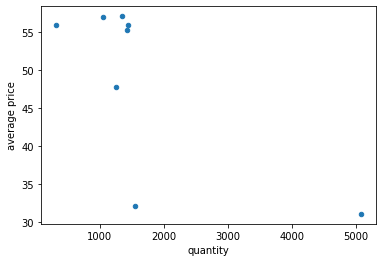

In [ ]:
F.plot(x='quantity', y='average_price', kind='scatter')
plt.xlabel('quantity')
plt.ylabel('average price')
plt.show()

## ARIMA

In [ ]:
from pandas.plotting import autocorrelation_plot

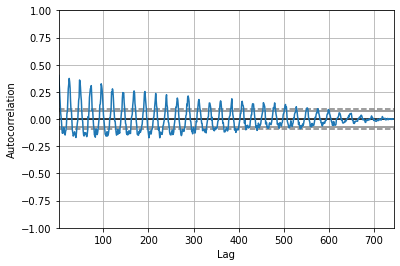

In [ ]:
autocorrelation_plot(ordersquantity1)

In [ ]:
!pip install --user scipy==1.2.0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(ordersquantity1, order=(15,0,0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               quantity   No. Observations:                  744
Model:                    ARMA(15, 0)   Log Likelihood               -1593.870
Method:                       css-mle   S.D. of innovations              2.060
Date:                Thu, 03 Dec 2020   AIC                           3221.740
Time:                        00:34:33   BIC                           3300.144
Sample:                    03-01-2018   HQIC                          3251.962
                         - 03-31-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2741      0.102     22.251      0.000       2.074       2.474
ar.L1.quantity      0.2960      0.037      8.077      0.000       0.224       0.368
ar.L2.quantity      0.1588      

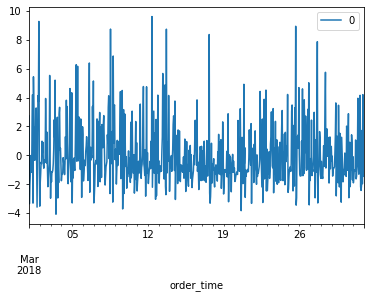

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

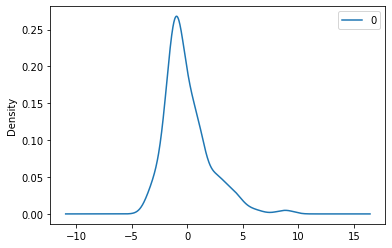

In [ ]:
residuals.plot(kind='kde')

In [ ]:
#residuals.columns=['residual']

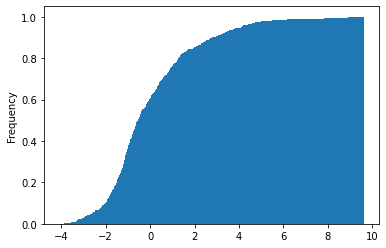

In [ ]:
residuals[0].plot(bins=300, kind='hist', density=True, cumulative=True)

In [ ]:
print(residuals.describe())

                0
count  744.000000
mean    -0.000323
std      2.063198
min     -4.088749
25%     -1.294658
50%     -0.522722
75%      0.902906
max      9.612565


In [ ]:
size = int(len(ordersquantity1) * 0.8)

In [ ]:
train, test = ordersquantity1[0:size], ordersquantity1[size:len(ordersquantity1)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

3.999266879160343


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

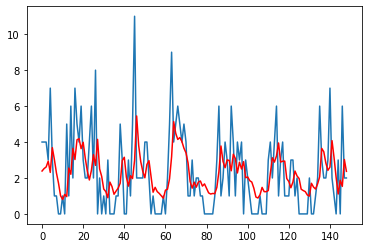

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

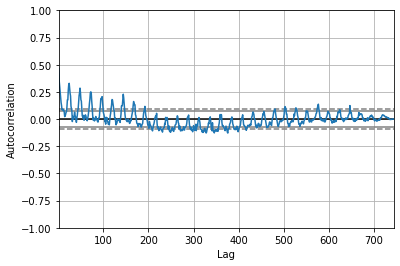

In [ ]:
autocorrelation_plot(ordersquantity2)

In [ ]:
model = ARIMA(ordersquantity2, order=(15,0,0))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               quantity   No. Observations:                  744
Model:                    ARMA(15, 0)   Log Likelihood               -1922.368
Method:                       css-mle   S.D. of innovations              3.205
Date:                Thu, 03 Dec 2020   AIC                           3878.737
Time:                        00:48:20   BIC                           3957.141
Sample:                    03-01-2018   HQIC                          3908.959
                         - 03-31-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9983      0.333      9.013      0.000       2.346       3.650
ar.L1.quantity      0.3668      0.037     10.012      0.000       0.295       0.439
ar.L2.quantity      0.1123      

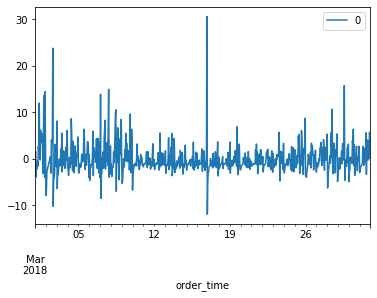

In [ ]:
residuals2 = pd.DataFrame(model_fit.resid)
residuals2.plot()

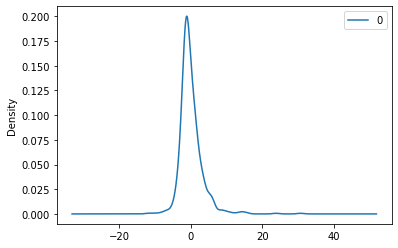

In [ ]:
residuals2.plot(kind='kde')

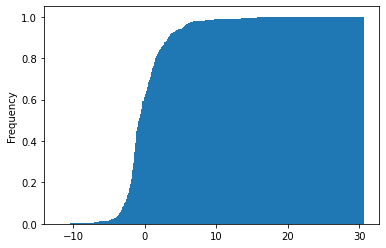

In [ ]:
residuals2[0].plot(bins=300, kind='hist', density=True, cumulative=True)

In [ ]:
print(residuals.describe())

                0
count  744.000000
mean    -0.000323
std      2.063198
min     -4.088749
25%     -1.294658
50%     -0.522722
75%      0.902906
max      9.612565


8.958236064826359


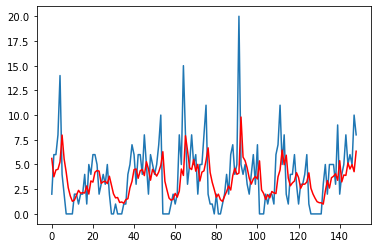

In [ ]:
size = int(len(ordersquantity2) * 0.8)
train, test = ordersquantity2[0:size], ordersquantity2[size:len(ordersquantity2)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = sk.mean_squared_error(test, predictions)
print(error)
test=pd.DataFrame(test)
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

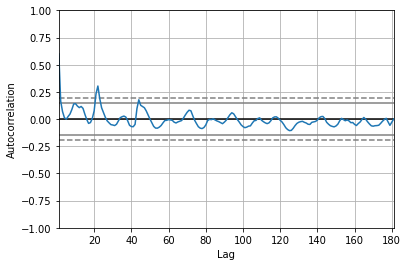

In [ ]:
autocorrelation_plot(ordersquantity3)

In [ ]:
model = ARIMA(ordersquantity3, order=(15,0,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                              ARMA Model Results                              
Dep. Variable:               quantity   No. Observations:                  181
Model:                    ARMA(15, 1)   Log Likelihood               -1021.727
Method:                       css-mle   S.D. of innovations             67.821
Date:                Thu, 03 Dec 2020   AIC                           2079.455
Time:                        01:05:28   BIC                           2137.028
Sample:                    03-01-2018   HQIC                          2102.796
                         - 03-08-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              55.1367        nan        nan        nan         nan         nan
ar.L1.quantity      1.9180      0.073     26.351      0.000       1.775       2.061
ar.L2.quantity     -1.1672      

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


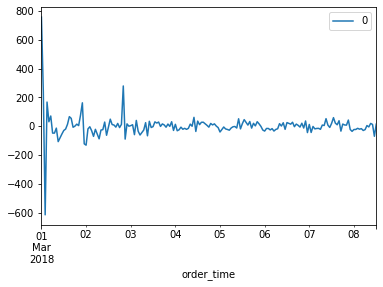

In [ ]:
residuals3 = pd.DataFrame(model_fit.resid)
residuals3.plot()

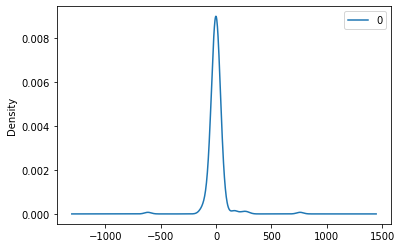

In [ ]:
residuals3.plot(kind='kde')

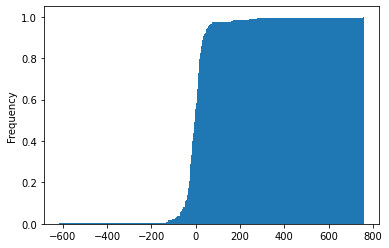

In [ ]:
residuals3[0].plot(bins=300, kind='hist', density=True, cumulative=True)

In [ ]:
print(residuals.describe())

                0
count  744.000000
mean    -0.000323
std      2.063198
min     -4.088749
25%     -1.294658
50%     -0.522722
75%      0.902906
max      9.612565


In [ ]:
size = int(len(ordersquantity3) * 0.8)
train, test = ordersquantity3[0:size], ordersquantity3[size:len(ordersquantity3)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = sk.mean_squared_error(test, predictions)
print(error)
test=pd.DataFrame(test)
test=test.reset_index().quantity

In [ ]:
print(error)

674.6451285821333


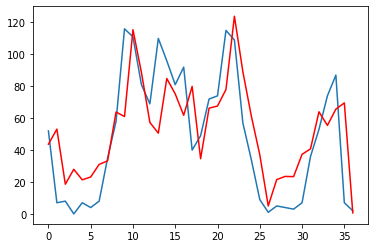

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

## Naive forecasting

In [ ]:
size = int(len(ordersquantity1) * 0.8)
train, test = ordersquantity1[0:size], ordersquantity1[size:len(ordersquantity1)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = history[-1]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

6.382550335570469


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

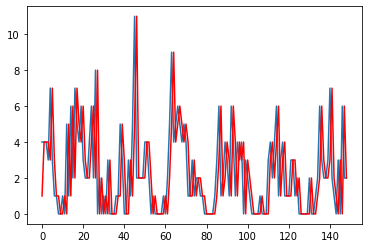

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 4 <br>
Naive Forecast MSE 6.38

In [ ]:
size = int(len(ordersquantity2) * 0.8)
train, test = ordersquantity2[0:size], ordersquantity2[size:len(ordersquantity2)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = history[-1]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

11.93288590604027


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

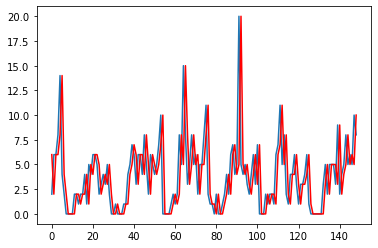

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')ARIMA MSE 4,
Naive Forecast MSE 6.38

ARIMA MSE: 8.96 <br>
Naive Forecast MSE: 11.93

In [ ]:
size = int(len(ordersquantity3) * 0.8)
train, test = ordersquantity3[0:size], ordersquantity3[size:len(ordersquantity3)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = history[-1]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

736.081081081081


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

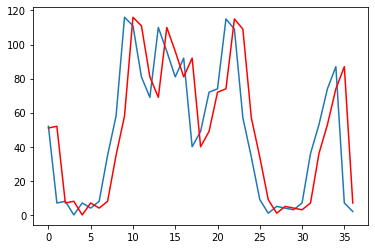

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 674 <br>
Naive Forecast MSE: 736

## Moving Average (average of last 10 observations)

In [ ]:
size = int(len(ordersquantity1) * 0.8)
train, test = ordersquantity1[0:size], ordersquantity1[size:len(ordersquantity1)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = (sum(history[-3:-1])+history[-1])/3
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

4.870246085011186


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

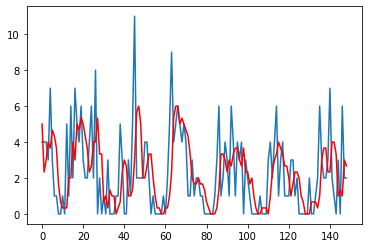

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 4 <br>
Moving Average MSE: 5.70, <br>
Naive forecast MSE 6.38

In [ ]:
size = int(len(ordersquantity2) * 0.8)
train, test = ordersquantity2[0:size], ordersquantity2[size:len(ordersquantity2)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = (sum(history[-10:-1])+history[-1])/10
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

12.481543624161073


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

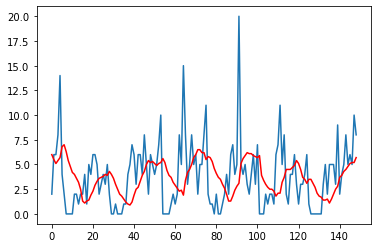

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 8.96 <br>
Moving Average MSE: 12.48 <br>
Naive forecast MSE: 11.93


In [ ]:
size = int(len(ordersquantity3) * 0.8)
train, test = ordersquantity3[0:size], ordersquantity3[size:len(ordersquantity3)]

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	yhat = (sum(history[-10:-1])+history[-1])/10
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

1856.9091891891892


In [ ]:
test=pd.DataFrame(test)

In [ ]:
test=test.reset_index().quantity

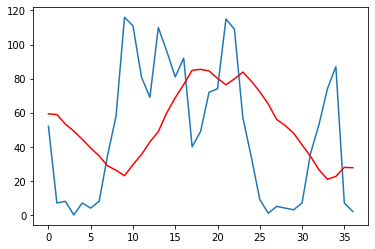

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 674 <br>
Moving Average MSE: 1856 <br>
Naive forecast MSE: 736

## Exponential Smoothing

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [ ]:
size = int(len(ordersquantity1) * 0.8)
train, test = ordersquantity1[0:size], ordersquantity1[size:len(ordersquantity1)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model=SimpleExpSmoothing(history)
	model_fit=model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)


In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)
test=pd.DataFrame(test)
test=test.reset_index().quantity

4.589901536829588


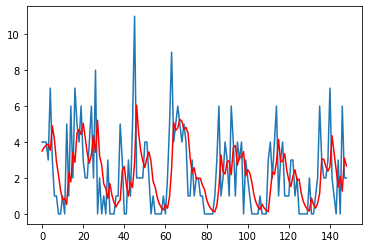

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 4 <br>
Exponential Smoothing: 4.59 <br> 
Moving Average MSE: 5.70 <br>
Naive forecast MSE: 6.38

In [ ]:
size = int(len(ordersquantity2) * 0.8)
train, test = ordersquantity2[0:size], ordersquantity2[size:len(ordersquantity2)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model=SimpleExpSmoothing(history)
	model_fit=model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)
test=pd.DataFrame(test)
test=test.reset_index().quantity

9.818849574523034


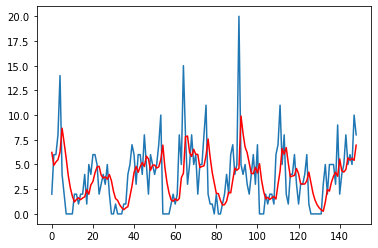

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 8.96 <br>
Exponential Smoothing: 9.82 <br>
Moving Average MSE: 12.48 <br>
Naive forecast MSE: 11.93

In [ ]:
size = int(len(ordersquantity3) * 0.8)
train, test = ordersquantity3[0:size], ordersquantity3[size:len(ordersquantity3)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model=SimpleExpSmoothing(history)
	model_fit=model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)


In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)
test=pd.DataFrame(test)
test=test.reset_index().quantity

736.1101955044385


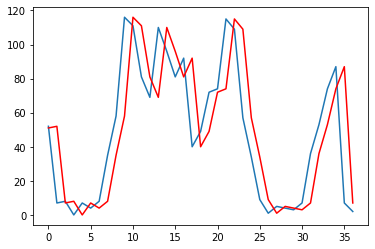

In [ ]:
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 674 <br>
Exponential Smoothing: 736 <br>
Moving Average MSE: 1856 <br>
Naive forecast MSE: 736

## SARIMA(Box-Jenkins)

### first

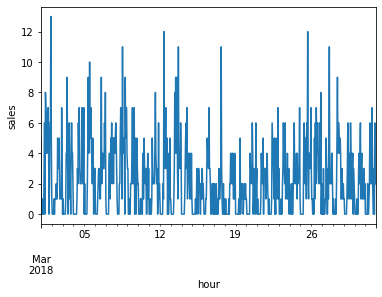

In [ ]:
ordersquantity1.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

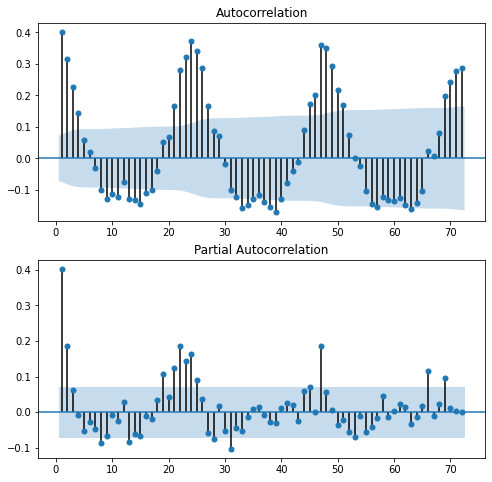

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
# Make ACF plot
plot_acf(ordersquantity1, lags=72, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(ordersquantity1, lags=72, zero=False, ax=ax2)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
results = adfuller(ordersquantity1)
print(results)

(-5.308062124416849, 5.268978760372717e-06, 20, 723, {'1%': -3.4394269973845657, '5%': -2.8655458544300387, '10%': -2.568903174551249}, 3106.547111048415)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(ordersquantity1, freq=24)

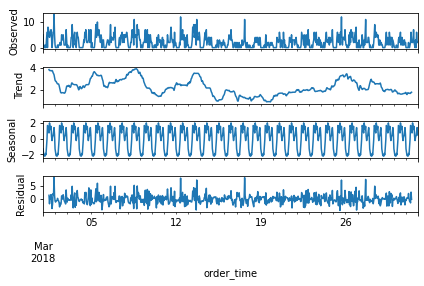

In [ ]:
decomp_results.plot()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


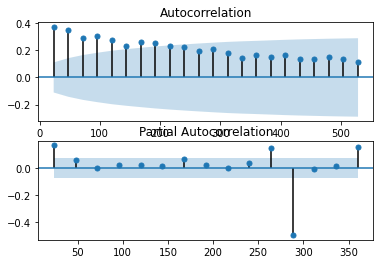

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(ordersquantity1, lags=[24,48,72,96,120,144, 168, 192,216,240,264,288,312,336,360,384,408,432,456,480,504,528], ax=ax1)
# Plot seasonal PACF
plot_pacf(ordersquantity1, lags=[24,48,72,96,120,144, 168, 192,216,240,264,288,312,336,360], ax=ax2)
plt.show()

In [ ]:
difs1=ordersquantity1.diff(24).dropna()

In [ ]:
dif1=ordersquantity1.diff().dropna()

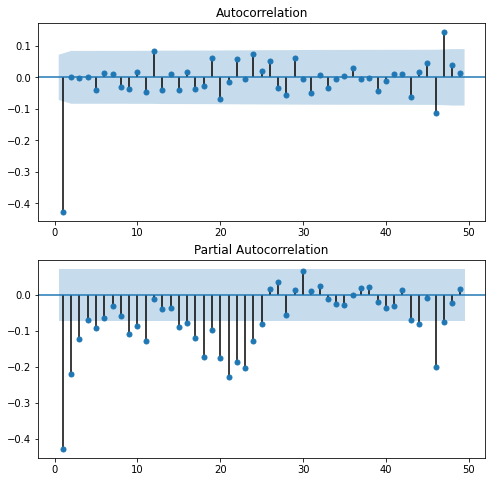

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(dif1, lags=49, zero=False, ax=ax1)
plot_pacf(dif1, lags=49, zero=False, ax=ax2)
plt.show()

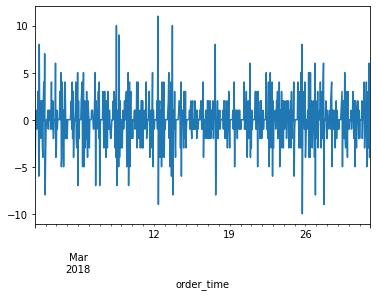

In [ ]:
dif1.plot()

In [ ]:
import pmdarima as pm

In [ ]:
results=pm.auto_arima(ordersquantity1, d=1,seasonal=True, m=24, D=0, max_P=1, max_Q=1, max_p=6, max_q=6, information_criterio='aic', trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=13.22 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=3505.364, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3349.179, Time=1.05 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3267.435, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=3503.366, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=3295.153, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=7.05 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=3247.519, Time=1.51 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=3502.992, Time=0.68 sec
 ARIMA(1,1,1)(1,0,0)[24] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(0,1,2)(1,0,0)[24] intercept   : AIC=3220.814, Time=2.99 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=3293.785, Time=0.23 sec
 ARIMA(0,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=8.43 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=3241.217, Time=3.22 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   :

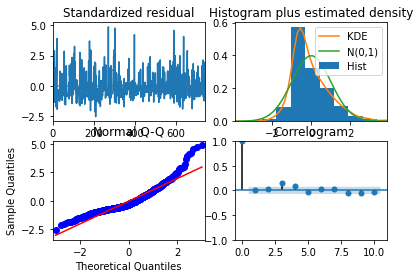

In [ ]:
results.plot_diagnostics()
plt.show()

In [ ]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  744
Model:             SARIMAX(0, 1, 3)x(1, 0, [], 24)   Log Likelihood               -1598.966
Date:                             Tue, 08 Dec 2020   AIC                           3207.933
Time:                                     02:00:16   BIC                           3230.986
Sample:                                          0   HQIC                          3216.820
                                             - 744                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7652      0.036    -21.152      0.000      -0.836      -0.694
ma.L2         -0.0945      

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
size = int(len(ordersquantity1) * 0.8)
train, test = ordersquantity1[0:size], ordersquantity1[size:len(ordersquantity1)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SARIMAX(history, order=(0,1,3), seasonal_order=(1,0,0,24))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = sk.mean_squared_error(test, predictions)
print(error)

4.078108510456416


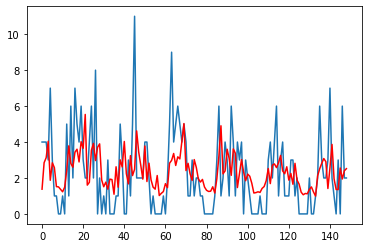

In [ ]:
test=pd.DataFrame(test)
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 4 <br>
Exponential Smoothing: 4.59 <br> 
Moving Average MSE: 5.70 <br>
Naive forecast MSE: 6.38 <br>
SARIMA MSE: 4.08 

### second

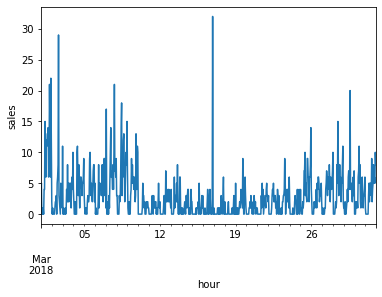

In [ ]:
ordersquantity2.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

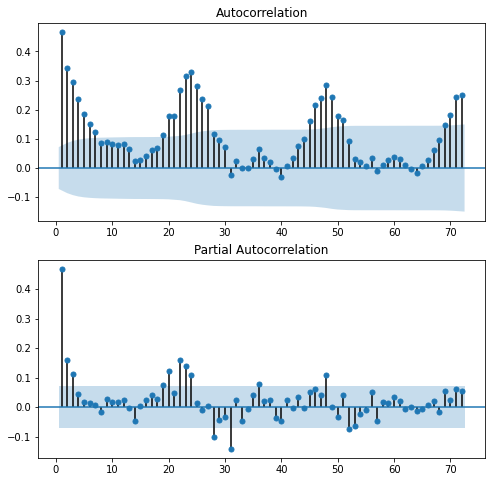

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
# Make ACF plot
plot_acf(ordersquantity2, lags=72, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(ordersquantity2, lags=72, zero=False, ax=ax2)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
results = adfuller(ordersquantity2)
print(results)

(-9.648131156776493, 1.4590773304867293e-16, 2, 741, {'1%': -3.4392057325732104, '5%': -2.8654483492874236, '10%': -2.5688512291811225}, 3716.625456042135)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(ordersquantity2, freq=24)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


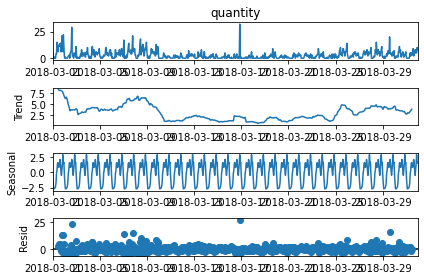

In [ ]:
decomp_results.plot()
plt.show()

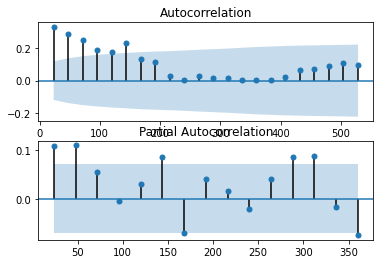

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(ordersquantity2, lags=[24,48,72,96,120,144, 168, 192,216,240,264,288,312,336,360,384,408,432,456,480,504,528], ax=ax1)
# Plot seasonal PACF
plot_pacf(ordersquantity2, lags=[24,48,72,96,120,144, 168, 192,216,240,264,288,312,336,360], ax=ax2)
plt.show()

In [ ]:
difs2=ordersquantity2.diff(24).dropna()

In [ ]:
dif2=ordersquantity2.diff().dropna()

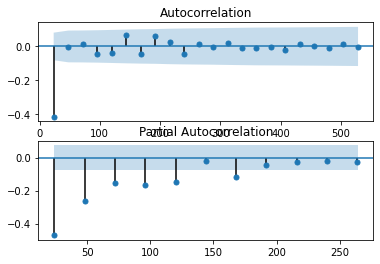

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(difs2, lags=[24,48,72,96,120,144, 168, 192,216,240,264,288,312,336,360,384,408,432,456,480,504,528], ax=ax1)
# Plot seasonal PACF
plot_pacf(difs2, lags=[24,48,72,96,120,144, 168, 192,216,240,264], ax=ax2)
plt.show()

In [ ]:
results = adfuller(difs2)
print(results)

(-22.167522684544434, 0.0, 0, 719, {'1%': -3.439477677285233, '5%': -2.865568186630048, '10%': -2.5689150720653977}, 3863.6438151979296)


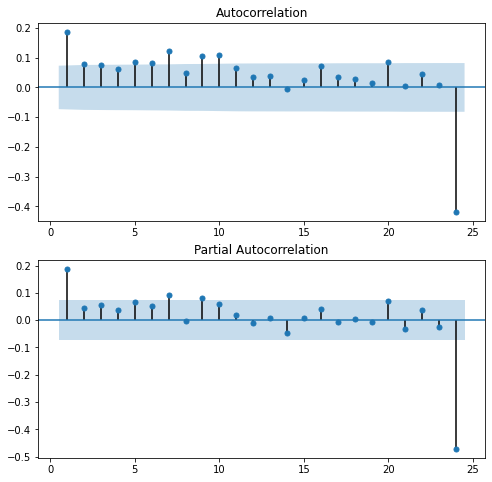

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(difs2, ax=ax1, lags=24, zero=False)
plot_pacf(difs2, ax=ax2, lags=24, zero=False)
plt.show()

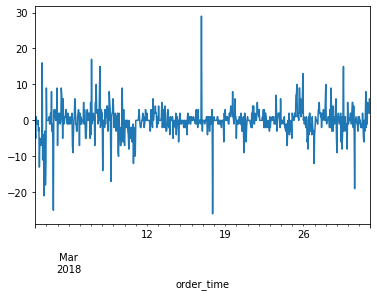

In [ ]:
difs2.plot()

In [ ]:
import pmdarima as pm

In [ ]:
results=pm.auto_arima(ordersquantity2, d=0,seasonal=True, m=24, D=1, max_P=1, max_Q=1, max_p=9, max_q=9, information_criterio='aic', trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[24] intercept   : AIC=inf, Time=35.11 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=4065.278, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=3863.247, Time=4.87 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=3760.865, Time=4.52 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=4064.297, Time=0.14 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=4044.194, Time=0.75 sec
 ARIMA(0,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=6.50 sec
 ARIMA(0,0,1)(1,1,0)[24] intercept   : AIC=3869.917, Time=3.48 sec
 ARIMA(0,0,0)(0,1,1)[24] intercept   : AIC=3806.145, Time=2.91 sec
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=17.43 sec
 ARIMA(0,0,2)(0,1,1)[24] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(1,0,2)(0,1,1)[24] intercept   : AIC=inf, Time=26.67 sec
 ARIMA(0,0,1)(0,1,1)[24]             : AIC=3760.886, Time=2.89 sec

Best model:  ARIMA(0,0,1)(0,1,1)[24] intercep

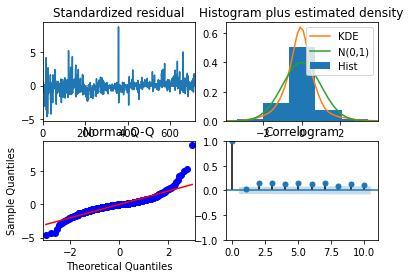

In [ ]:
results.plot_diagnostics()
plt.show()

In [ ]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  744
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 24)   Log Likelihood               -1876.432
Date:                            Tue, 08 Dec 2020   AIC                           3760.865
Time:                                    00:28:10   BIC                           3779.182
Sample:                                         0   HQIC                          3767.936
                                            - 744                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0536      0.048     -1.113      0.266      -0.148       0.041
ma.L1          0.2373      0.023   

In [ ]:
size = int(len(ordersquantity2) * 0.8)
train, test = ordersquantity2[0:size], ordersquantity2[size:len(ordersquantity2)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SARIMAX(history, order=(0,0,1), seasonal_order=(0,1,1,24))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

8.280047093211044


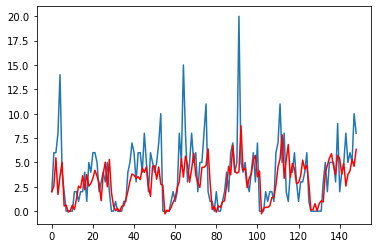

In [ ]:
test=pd.DataFrame(test)
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 8.96 <br>
Exponential Smoothing: 9.82 <br>
Moving Average MSE: 12.48 <br>
Naive forecast MSE: 11.93 <br>
SARIMA MSE: 8.28

### third

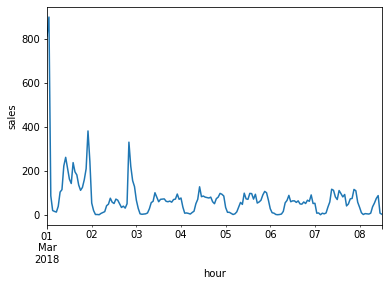

In [ ]:
ordersquantity3.plot(y='quantity')
plt.xlabel('hour')
plt.ylabel('sales')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

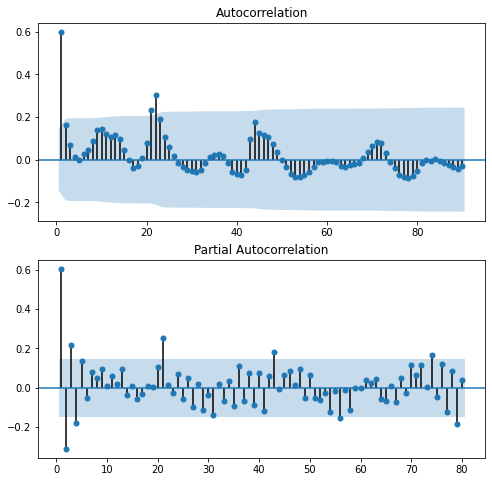

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
# Make ACF plot
plot_acf(ordersquantity3, lags=90, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(ordersquantity3, lags=80, zero=False, ax=ax2)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
results = adfuller(ordersquantity3)
print(results)

(-14.446556639131412, 7.213540869662227e-27, 1, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 1667.306385504227)


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_results = seasonal_decompose(ordersquantity2, freq=24)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


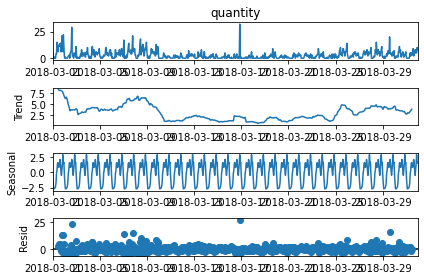

In [ ]:
decomp_results.plot()
plt.show()

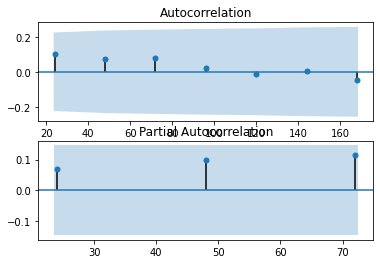

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(ordersquantity3, lags=[24,48,72,96,120,144, 168], ax=ax1)
# Plot seasonal PACF
plot_pacf(ordersquantity3, lags=[24,48,72], ax=ax2)
plt.show()

In [ ]:
dif3=ordersquantity3.diff().dropna()

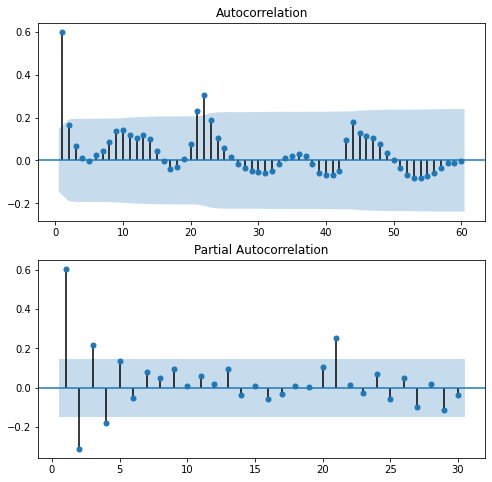

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(ordersquantity3, ax=ax1, lags=60, zero=False)
plot_pacf(ordersquantity3, ax=ax2, lags=30, zero=False)
plt.show()

In [ ]:
order_aic=[]
for p in range(3):
  for q in range(3):
    try:
      model = SARIMAX(ordersquantity3, order=(p,0,q))
      results = model.fit()
      order_aic.append((p,q,results.aic))
    except:
      print(p, q, None, None)
order_df=pd.DataFrame(order_aic, columns=['p','q','aic'])


In [ ]:
print(order_df.sort_values('aic'))

   p  q          aic
8  2  2  2065.656778
3  1  0  2071.668384
4  1  1  2072.033581
6  2  0  2072.138836
5  1  2  2073.776873
7  2  1  2074.988765
2  0  2  2097.250463
1  0  1  2129.612444
0  0  0  2268.119353


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


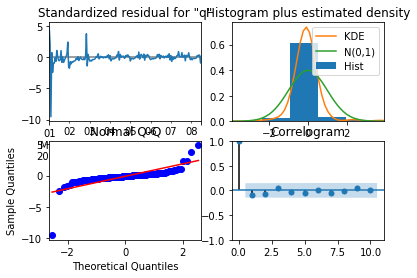

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  181
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1027.828
Date:                Tue, 08 Dec 2020   AIC                           2065.657
Time:                        01:47:54   BIC                           2081.649
Sample:                    03-01-2018   HQIC                          2072.140
                         - 03-08-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4838      0.070     21.173      0.000       1.346       1.621
ar.L2         -0.4853      0.070     -6.968      0.000      -0.622      -0.349
ma.L1         -0.5516      0.081     -6.827      0.0

In [ ]:
model=SARIMAX(ordersquantity3, order=(2,0,2))
model_fit=model.fit()
model_fit.plot_diagnostics()
plt.show()
print(model_fit.summary())

In [ ]:
size = int(len(ordersquantity3) * 0.8)
train, test = ordersquantity3[0:size], ordersquantity3[size:len(ordersquantity3)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = SARIMAX(history, order=(2,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

In [ ]:
error = sk.mean_squared_error(test, predictions)
print(error)

665.0935793629002


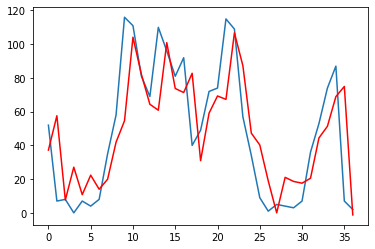

In [ ]:
test=pd.DataFrame(test)
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 674 <br>
Exponential Smoothing: 736 <br>
Moving Average MSE: 1856 <br>
Naive forecast MSE: 736 <br>
SARIMA MSE: 665

## SARIMAX (with price)

**SARIMAX model is produced by adding price as a covaiate to SARIMA.**

### first

In [ ]:
columns=['quantity','average_price']
A=pd.DataFrame(columns=columns)
A['quantity']=orders1['quantity'].resample('H').sum()
A['average_price']=orders1['final_unit_price'].resample('H').mean()
A=A.dropna()

In [ ]:
A=A.reset_index()
size = int(len(A) * 0.8)
train, test = A[0:size], A[size:len(A)]
history = train
quantity_series=history['quantity']
average_price_series=history['average_price']
test_price=test['average_price']
predictions = list()
for t in range(len(test)):
  model = SARIMAX(quantity_series, order=(0,1,3), seasonal_order=(1,0,0,24), exog=average_price_series)
  model_fit = model.fit()
  output = model_fit.forecast(exog=test_price[size+t])
  yhat = output[size+t]
  predictions.append(yhat)
  quantity_obs = test.iloc[t,1]
  price_obs=test.iloc[t,2]
  quantity_obs=pd.Series(quantity_obs, index=[size+t])
  price_obs=pd.Series(price_obs, index=[size+t])
  quantity_series=quantity_series.append(quantity_obs)
  average_price_series=average_price_series.append(price_obs)

In [ ]:
error = sk.mean_squared_error(test['quantity'], predictions)
print(error)

3.9602925551386727


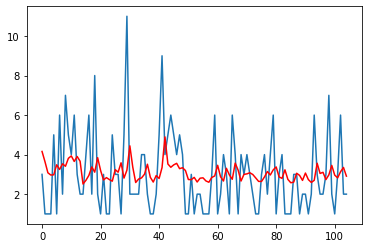

In [ ]:
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 4 <br>
Exponential Smoothing: 4.59 <br> 
Moving Average MSE: 5.70 <br>
Naive forecast MSE: 6.38 <br>
SARIMA MSE: 4.08 <br>
SARIMAX MSE: 3.96

### second

In [ ]:
columns=['quantity','average_price']
A=pd.DataFrame(columns=columns)
A['quantity']=orders2['quantity'].resample('H').sum()
A['average_price']=orders2['final_unit_price'].resample('H').mean()
A=A.dropna()

In [ ]:
A=A.reset_index()
size = int(len(A) * 0.8)
train, test = A[0:size], A[size:len(A)]
history = train
quantity_series=history['quantity']
average_price_series=history['average_price']
test_price=test['average_price']
predictions = list()
for t in range(len(test)):
  model = SARIMAX(quantity_series, order=(0,0,1), seasonal_order=(0,1,1,24), exog=average_price_series)
  model_fit = model.fit()
  output = model_fit.forecast(exog=test_price[size+t])
  yhat = output[size+t]
  predictions.append(yhat)
  quantity_obs = test.iloc[t,1]
  price_obs=test.iloc[t,2]
  quantity_obs=pd.Series(quantity_obs, index=[size+t])
  price_obs=pd.Series(price_obs, index=[size+t])
  quantity_series=quantity_series.append(quantity_obs)
  average_price_series=average_price_series.append(price_obs)

In [ ]:
error = sk.mean_squared_error(test['quantity'], predictions)
print(error)

9.828675633912685


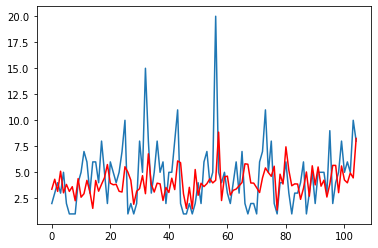

In [ ]:
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 8.96 <br>
Exponential Smoothing: 9.82 <br>
Moving Average MSE: 12.48 <br>
Naive forecast MSE: 11.93 <br>
SARIMA MSE: 8.28 <br>
SARIMAX MSE: 9.83

### third

In [ ]:
columns=['quantity','average_price']
A=pd.DataFrame(columns=columns)
A['quantity']=orders3['quantity'].resample('H').sum()
A['average_price']=orders3['final_unit_price'].resample('H').mean()
A=A.dropna()

In [ ]:
A=A.reset_index()
size = int(len(A) * 0.8)
train, test = A[0:size], A[size:len(A)]
history = train
quantity_series=history['quantity']
average_price_series=history['average_price']
test_price=test['average_price']
predictions = list()
for t in range(len(test)):
  model = SARIMAX(quantity_series, order=(2,0,2), exog=average_price_series)
  model_fit = model.fit()
  output = model_fit.forecast(exog=test_price[size+t])
  yhat = output[size+t]
  predictions.append(yhat)
  quantity_obs = test.iloc[t,1]
  price_obs=test.iloc[t,2]
  quantity_obs=pd.Series(quantity_obs, index=[size+t])
  price_obs=pd.Series(price_obs, index=[size+t])
  quantity_series=quantity_series.append(quantity_obs)
  average_price_series=average_price_series.append(price_obs)

In [ ]:
error = sk.mean_squared_error(test['quantity'], predictions)
print(error)

699.5726461424142


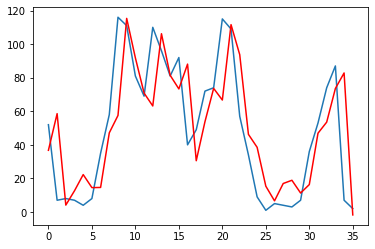

In [ ]:
test=test.reset_index().quantity
plt.plot(test)
plt.plot(predictions, color='red')

ARIMA MSE: 674 <br>
Exponential Smoothing: 736 <br>
Moving Average MSE: 1856 <br>
Naive forecast MSE: 736 <br>
SARIMA MSE: 665 <br>
SARIMAX MSE: 699

## Final results

### SKU 1

ARIMA MSE: 4 <br>
Exponential Smoothing: 4.59 <br> 
Moving Average MSE: 5.70 <br>
Naive forecast MSE: 6.38 <br>
SARIMA MSE: 4.08 <br>
SARIMAX MSE: 3.96

### SKU 2

ARIMA MSE: 8.96 <br>
Exponential Smoothing: 9.82 <br>
Moving Average MSE: 12.48 <br>
Naive forecast MSE: 11.93 <br>
SARIMA MSE: 8.28 <br>
SARIMAX: 9.83

### SKU 3

ARIMA MSE: 674 <br>
Exponential Smoothing: 736 <br>
Moving Average MSE: 1856 <br>
Naive forecast MSE: 736 <br>
SARIMA MSE: 665 <br>
SARIMAX: 699

**Among the models examined so far, SARIMA had the best performance, and after that ARIMA had the higher performance across several SKUs. In the next step more traditional and machine learning models will be implemented across alot more SKUs to find the most effiecint model. I will also combine different models to come up with even higher performing models.**